# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [2]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

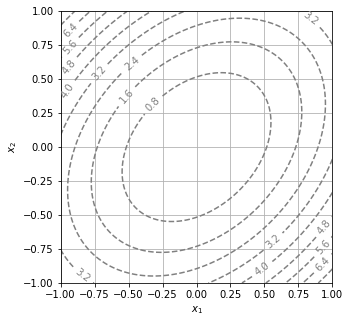

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

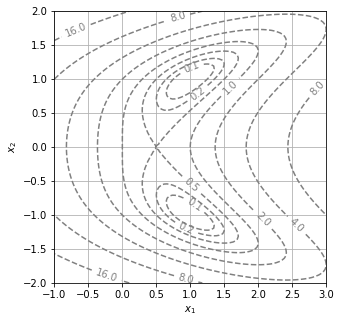

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y)

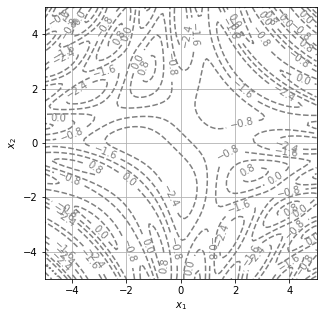

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

**Réponse**
L'application à laquelle nous destinons cette fonction ne nécessite pas une grande précision,
surtout que l'exécution serait très longue pour une grande précision (on est limité par la puissance de l'ordinateur).
La valeur de epsilon choisie paraît suffisamment petite au vu des variations que l'on pourrait discerner sur les graphiques.

In [14]:
N = 100
eps = 0.001

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    for i in range(N):
        J_f=J(F)(x0,y0)
        J_inv=np.linalg.inv(J_f)
        x,y=-np.dot(J_inv,F(x0,y0))+np.array([x0,y0])
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return [x, y]
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#rajouter les points sur une courbe

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [16]:
def f1p(x,y):
    x1,y1=f1(x,y)-0.8,x-y
    return np.array([x1,y1])
print(Newton(f1p,0.8,0.8,eps,N))


[0.4472135970019964, 0.4472135970019964]


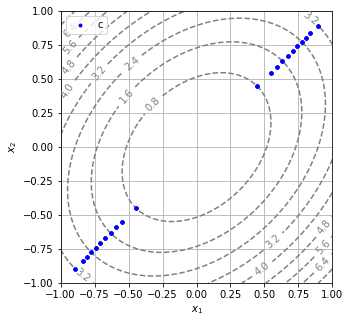

In [17]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
x,y=np.linspace(-1,1,10),np.linspace(-1,1,10)
X=[]
Y=[]
for i in [0.8,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.2]:
    for j in range (0,len(x)):
        def f1i(x,y):
            x1,y1=f1(x,y)-i,x-y
            return np.array([x1,y1])
        X.append(Newton(f1i,x[j],x[j],eps,N)[0])
        Y.append(Newton(f1i,x[j],y[j],eps,N)[1])
plt.plot(X,Y,'b.')
plt.legend('contrainte x=y')

plt.show()

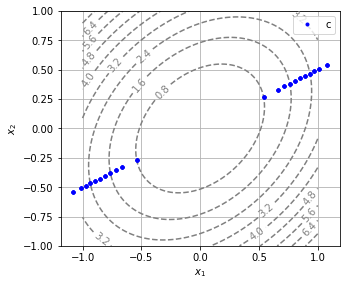

In [18]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
X=[]
Y=[]
for i in [0.8,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.2]:
    for j in range (0,len(x)):
        def f1i(x,y):
            x1,y1=f1(x,y)-i,x-2*y
            return np.array([x1,y1])
        X.append(Newton(f1i,x[j],x[j],eps,N)[0])
        Y.append(Newton(f1i,x[j],y[j],eps,N)[1])
plt.plot(X,Y,'b.')
plt.legend('contrainte x=2y')
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

**Réponse**
On part du point de référence et on "avance" sur la ligne de niveau selon le vecteur de norme delta et de direction perpendiculaire au gradient puis on applique la fonction Newton pour se replacer correctement.

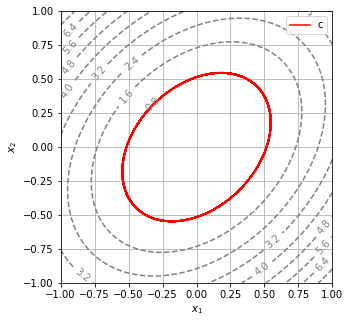

In [19]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps,c=0.8):
    tab=np.zeros((N,2))
    tab[0]=[x0,y0]
    for i in range (N-1):
        dirx,diry=(grad(f)(x0,y0))/(np.linalg.norm(grad(f)(x0,y0)))*delta
        x1=x0-diry
        y1=y0+dirx
        def fbis(x,y,x0,y0,c):
            return np.array([f(x,y)-c, np.sqrt((x-x0)**2+(y-y0)**2)-delta])
        x0,y0=Newton(lambda x1,y1 :fbis(x1,y1,x0,y0,c),x1, y1, eps=eps, N=100)
        tab[i+1]=[x0,y0]
    return tab
c=0.9
delta=0.1
x,y=Newton(f1p,0.6,0.6,eps,N)
tab=level_curve(f1,x,y,0.1,1000,eps,0.8)
plt.plot(tab[:,0],tab[:,1],'r')
plt.legend('courbes de niveau pour f1')
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

**Réponse**
Pour chaque nouveau point, on vérifie que sa distance au premier est supérieur à delta.

In [37]:
def level_curve_corrigée(f, x0, y0, delta=0.1, N=1000, eps=eps,c=0.8):
    tab=[[x0,y0]]
    for i in range (N-1):
        dirx,diry=(grad(f)(x0,y0))/(np.linalg.norm(grad(f)(x0,y0)))*delta
        x1=x0-diry
        y1=y0+dirx
        def fbis(x,y,x0,y0,c):
            return np.array([f(x,y)-c, np.sqrt((x-x0)**2+(y-y0)**2)-delta])
        x0,y0=Newton(lambda x1,y1 :fbis(x1,y1,x0,y0,c),x1, y1, eps=eps, N=100)
        if np.sqrt((x0-tab[0][0])**2+(y0-tab[0][1])**2)<delta:
            return np.array(tab)
        else:
            tab.append([x0,y0])
    return np.array(tab)


**Question** Valider graphiquement le résultat au moyen des exemples de référence.

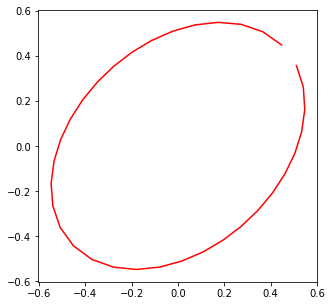

In [38]:
x0,y0=Newton(f1p,0.6,0.6,eps,N)
tab=level_curve_corrigée(f1, x0, y0, delta=0.1, N=10000, eps=eps,c=0.8)
plt.plot(tab[:,0],tab[:,1],'r')

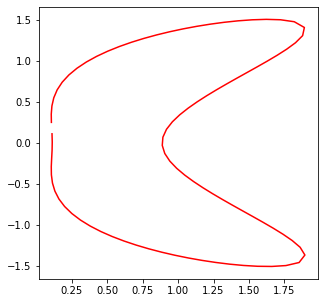

In [41]:
def f2p(x,y):
    x1,y1=f2(x,y)-0.8,x-y
    return np.array([x1,y1])
x0,y0=Newton(f2p,0.6,0.6,eps,N)
tab=level_curve_corrigée(f2, x0, y0, delta=0.1, N=10000, eps=eps,c=0.8)
plt.plot(tab[:,0],tab[:,1],'r')

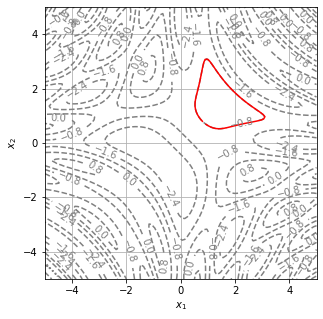

In [42]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
def f3p(x,y):  #on implémente la fonction pour trouver le point de départ
    x1,y1=f3(x,y)+0.8,x-y
    return np.array([x1,y1])

x0,y0=Newton(f3p,0.6,0.6,eps,N)
tab=level_curve_corrigée(f3, x0, y0, 0.1, 1000, eps,-0.8)
plt.plot(tab[:,0],tab[:,1],'r')

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [43]:
a=-2
b=2
def area_squares(f,c,h):
    A=0
    n=int((b-a)//h)
    X=np.linspace(a,b,n) #quadrillage arbitraire pur l'instant
    Y=np.linspace(a,b,n)#quadrillage arbitraire pour l'instant
    for i in X:
        for j in X:
            if f(i,j)<=c:
                A+=1
    return A*h**2

def circle(x,y):
    return np.sqrt(x**2 + y**2)

area_squares(circle,1,0.001)

3.1384209999999997

On étudie le comportement de l'erreur 

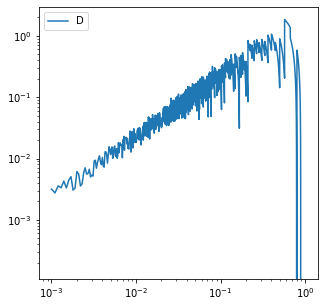

In [44]:
np.vectorize(area_squares)
X=np.linspace(10e-4,1,10000)
Y=[]
for i in X:
    Y.append(np.pi-area_squares(circle,1,i))

plt.loglog(X,Y)
plt.legend("Diagramme log-log de l'erreur")
plt.show()


**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


**Réponse**
On peut modifier cette approche en calculant les aires pour deux courbes de niveau c-epsilon et c+epsilon

In [48]:
a=-2
b=2
def area_squares_enc(f,c,h,epsilon):
    a=area_squares(f,c+epsilon,h)
    b=area_squares(f,c-epsilon,h)
    print(f"l'aire est comprise entre {b} et {a}")
area_squares_enc(circle,1,0.001,0.00001)

l'aire est comprise entre 3.138365 et 3.138461


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [49]:
X=level_curve_corrigée(circle,1.0, 0.0, 0.01, 10000000, 0.001,1)[:,0]
Y=level_curve_corrigée(circle, 1.0, 0.0, 0.01, 10000000, 0.001,1)[:,1]
p=np.random.randint(0,len(X))
A=0
#on utilise le déterminant 
for i in range (0,len(X)):
    if i==len(X)-1:
        M=[[1.0,1.0,1],[X[i],Y[i],1.0],[X[0],Y[0],1.0]]
        A+=1/2*np.linalg.det(M)

    else:
        M=[[1.0,1.0,1],[X[i],Y[i],1.0],[X[i+1],Y[i+1],1.0]]
        A+=1/2*np.linalg.det(M)


print(f"L'aire du cercle est {A}")


L'aire du cercle est 3.1415402147222795


On étudie ici la convergence de la méthode

3.141540214722308
3.1413829658997794
3.141118180648712
3.140754092908882
3.140253901515579
3.1396490950323166
3.1389254642052777
3.1381562443036093
3.137111080917001
3.1360151429011256


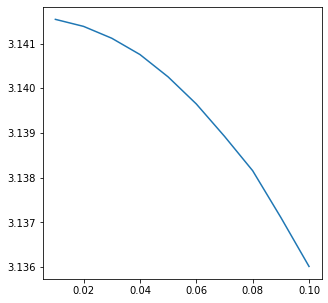

In [69]:
Z=np.linspace(0.01,0.1,10)
aire=[]
for i in Z:
    X=level_curve_corrigée(circle, 1.0, 0.0, delta=i, N=1000000, eps=eps,c=1)[:,0]
    Y=level_curve_corrigée(circle, 1.0, 0.0, delta=i, N=1000000, eps=eps,c=1)[:,1]
    A=0
#on utilise le déterminant
    for j in range (0,len(X)):
        if j==len(X)-1:
            M=[[0.0,0.0,1],[X[j],Y[j],1.0],[X[0],Y[0],1.0]]
            A+=1/2*np.linalg.det(M)
        else:
            M=[[0.0,0.0,1],[X[j],Y[j],1.0],[X[j+1],Y[j+1],1.0]]
            A+=1/2*np.linalg.det(M)
    aire.append(A)
    print(A)

plt.plot(Z,aire)
plt.show()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

**Réponse**
On réalise la meme fonction avec un point en dehors du cercle, ici le point de coordonées (1,1)

3.1360151429011216
3.1198405080676803
3.0840218198462015
3.044093065149939
2.9939516604913585
2.9338669930643544
2.7736399482567986
2.686942514063307
2.508814014460797
2.59807621874198


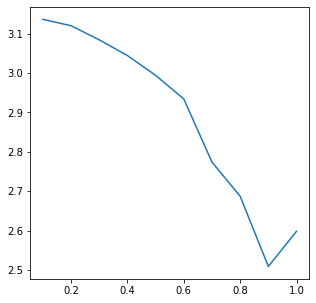

In [71]:
Z=np.linspace(0.1,1,10)
aire=[]
for j in Z:
    X=level_curve_corrigée(circle,1.0, 0.0, delta=j, N=100000000, eps=eps,c=1)[:,0]
    Y=level_curve_corrigée(circle, 1.0, 0.0, delta=j, N=100000000, eps=eps,c=1)[:,1]
    A=0
#on utilise le déterminant
    for i in range (0,len(X)):
        if i==len(X)-1:
            M=[[1.0,1.0,1],[X[i],Y[i],1.0],[X[0],Y[0],1.0]]
            A+=1/2*np.linalg.det(M)
        else:
            M=[[1.0,1.0,1],[X[i],Y[i],1.0],[X[i+1],Y[i+1],1.0]]
            A+=1/2*np.linalg.det(M)
    aire.append(A)
    print(A)
        
plt.plot(Z,aire)
plt.show()

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [72]:
#On définit ici une fonction qui décrit cet ensemble 
c1=level_curve_corrigée(circle,1.0, 0.0, delta=0.01, N=1000000, eps=eps,c=1)
c2=level_curve_corrigée(circle,-1.0, 0.0, delta=0.01, N=1000000, eps=eps,c=1)
X=np.concatenate([c1[:,0],c2[:,0],np.array([c1[0][0]])])
Y=np.concatenate([c1[:,1],c2[:,1],np.array([c1[0][1]])])
A=0
for i in range (0,len(X)):
    if i==len(X)-1:
        M=[[0.0,0.0,1],[X[i],Y[i],1.0],[X[0],Y[0],1.0]]
        A+=1/2*np.linalg.det(M)

    else:
        M=[[0.0,0.0,1],[X[i],Y[i],1.0],[X[i+1],Y[i+1],1.0]]
        A+=1/2*np.linalg.det(M)
print(f"L'aire de la figure est {A}")

L'aire de la figure est 6.256919570557125


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [73]:
def area_triangles(x,y):
    p=np.random.randint(0,len(x))
    A=0
    for i in range (0,len(x)):
        if i==len(X)-1:
            M=[[1.0,1.0,1],[X[i],Y[i],1.0],[X[0],Y[0],1.0]]
            A+=1/2*np.linalg.det(M)
        else:
            M=[[1.0,1.0,1],[X[i],Y[i],1.0],[X[i+1],Y[i+1],1.0]]
            A+=1/2*np.linalg.det(M)
    return A

**Comparaison des méthodes**
La méthode des carrés nécessite d'avoir une idée précise de la frontière de l'ensemble pour pouvoir quadriller l'espace alors que la méthode des triangles nécessite seulement la fonction dont on veut calculer l'aire, par l'intermédiaire de level_curve. 
Cependant la fonction triangle est moins précise car elle passe par l'approximation de la courbe par une succession de points pour calculer l'aire. La fonction triangle nécessite plus de puissance de calcul car elle réalise des calculs de déterminant alors que la fonction carré ne fait que des tests d'appartenance. 

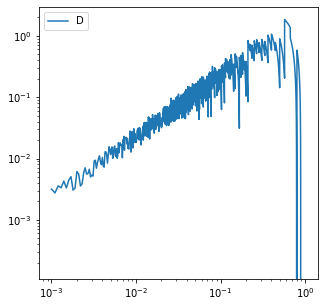

In [74]:
np.vectorize(area_squares)
X=np.linspace(10e-4,1,10000)
Y=[]
for i in X:
    Y.append(np.pi-area_squares(circle,1,i))

plt.loglog(X,Y)
plt.legend("Diagramme log-log de l'erreur")
plt.show()


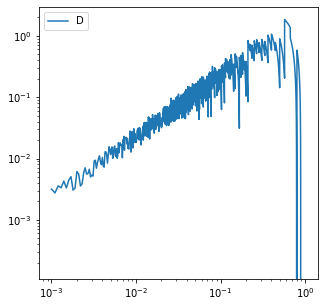

In [75]:
np.vectorize(area_triangles)
X=np.linspace(10e-4,1,10000)
Y=[]
for i in X:
    Y.append(np.pi-area_squares(circle,1,i))

plt.loglog(X,Y)
plt.legend("Diagramme log-log de l'erreur")
plt.show()